# 1.21a: Flannel 1 vs Flannel 2 Comparison

**Goal:** Compare W matrix evolution between Flannel 1 (tied weights) and Flannel 2 (untied weights).

## Questions

1. Are W₁[0] and W₂[0] identical? (They should be with same random seed)
2. How does ||W₁[t] - W₂[t]||_F evolve over time?
3. Is divergence driven by live tokens, dead tokens, or both?

## Hypothesis

**Flannel 1 (tied weights):** W = E (same tensor)
- W gets gradients from both embedding layer (input tokens only) and unembedding layer (all tokens)
- Dead tokens get unembedding gradients + zero from embedding path

**Flannel 2 (untied weights):** W and E are independent
- W gets only unembedding gradients (all tokens)
- E gets only embedding gradients (input tokens only)
- Dead tokens in W get only unembedding gradients

**Expected result:** W₁ and W₂ should diverge because:
- Live tokens in W₁ get additional embedding supervision
- Hidden states h[t] evolve differently (computed from W₁ vs E₂)
- Different hidden states → different unembedding gradients → different dead token trajectories

The Frobenius norm ||W₁[t] - W₂[t]||_F should grow over time.

## Parameters

In [9]:
# Model and data paths
MODEL_NAME = 'Flannel'
FLANNEL_1_PATH = '../tensors/Flannel/1.20a_flannel_1.safetensors'
FLANNEL_2_PATH = '../tensors/Flannel/1.20b_flannel_2.safetensors'
TOKEN_MASKS_PATH = '../tensors/Flannel/live_dead_tokens.safetensors'

# Visualization
PLOT_DPI = 150
COLORMAP = 'inferno'

## Imports

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [11]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Flannel 1 Data

Flannel 1: tied weights (W = E), only W recorded.

In [12]:
print("Loading Flannel 1 data...\n")

data_1 = load_file(FLANNEL_1_PATH)
masks = load_file(TOKEN_MASKS_PATH)

W_1 = data_1['embeddings'].to(torch.float32).to(device)  # Shape: (n_steps, vocab_size, hidden_dim)
dead_mask = masks['dead_mask'].to(device)  # Shape: (vocab_size,)
live_mask = masks['live_mask'].to(device)  # Shape: (vocab_size,)

n_steps, vocab_size, hidden_dim = W_1.shape
n_dead = dead_mask.sum().item()
n_live = live_mask.sum().item()

print(f"✓ Flannel 1 loaded")
print(f"  Shape: {W_1.shape}")
print(f"  Vocab: {vocab_size} ({n_live} live, {n_dead} dead)")
print(f"  Steps: {n_steps}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Device: {W_1.device}")

Loading Flannel 1 data...

✓ Flannel 1 loaded
  Shape: torch.Size([1001, 10000, 64])
  Vocab: 10000 (6301 live, 3699 dead)
  Steps: 1001
  Hidden dim: 64
  Device: mps:0


## Load Flannel 2 Data

Flannel 2: untied weights, both E and W recorded.

In [13]:
print("\nLoading Flannel 2 data...\n")

data_2 = load_file(FLANNEL_2_PATH)

W_2 = data_2['embeddings_W'].to(torch.float32).to(device)  # Shape: (n_steps, vocab_size, hidden_dim)
E_2 = data_2['embeddings_E'].to(torch.float32).to(device)  # Shape: (n_steps, vocab_size, hidden_dim)

print(f"✓ Flannel 2 loaded")
print(f"  W shape: {W_2.shape}")
print(f"  E shape: {E_2.shape}")
print(f"  Device: {W_2.device}")

# Sanity check: same dimensions
assert W_1.shape == W_2.shape, "W_1 and W_2 have different shapes!"
print(f"\n✓ Shapes match")


Loading Flannel 2 data...

✓ Flannel 2 loaded
  W shape: torch.Size([1001, 10000, 64])
  E shape: torch.Size([1001, 10000, 64])
  Device: mps:0

✓ Shapes match


## Check Initial Conditions: W₁[0] == W₂[0]?

Both experiments used the same random seed (42), so initialization should be identical.

In [14]:
print("\n" + "="*80)
print("INITIAL CONDITION CHECK: W₁[0] == W₂[0]?")
print("="*80 + "\n")

# Compute difference at t=0
diff_0 = W_1[0] - W_2[0]
frob_norm_0 = torch.norm(diff_0, p='fro').item()
max_diff_0 = torch.abs(diff_0).max().item()

print(f"Frobenius norm ||W₁[0] - W₂[0]||_F: {frob_norm_0:.10e}")
print(f"Max absolute difference: {max_diff_0:.10e}")
print()

if frob_norm_0 < 1e-6:
    print("✓ IDENTICAL INITIALIZATION")
    print("  W₁[0] and W₂[0] are numerically identical.")
    print("  Same random seed (42) produced identical starting points.")
else:
    print("✗ DIFFERENT INITIALIZATION")
    print("  W₁[0] and W₂[0] differ!")
    print("  This suggests different random seeds or initialization logic.")
    print("  Need to investigate why.")

print("\n" + "="*80)


INITIAL CONDITION CHECK: W₁[0] == W₂[0]?

Frobenius norm ||W₁[0] - W₂[0]||_F: 0.0000000000e+00
Max absolute difference: 0.0000000000e+00

✓ IDENTICAL INITIALIZATION
  W₁[0] and W₂[0] are numerically identical.
  Same random seed (42) produced identical starting points.



## Compute Frobenius Norm Over Time

For each timestep t, compute:

$$||W_1[t] - W_2[t]||_F = \sqrt{\sum_{i,j} (W_1[t]_{ij} - W_2[t]_{ij})^2}$$

This measures total divergence between the two matrices.

In [15]:
print("\nComputing Frobenius norm divergence over time...\n")

frob_norms = torch.zeros(n_steps, device=device)

for t in range(n_steps):
    diff = W_1[t] - W_2[t]
    frob_norms[t] = torch.norm(diff, p='fro')

frob_norms_cpu = frob_norms.cpu().numpy()

print(f"✓ Computed Frobenius norms for {n_steps} timesteps")
print(f"\nStatistics:")
print(f"  t=0: {frob_norms_cpu[0]:.6e}")
print(f"  t={n_steps-1}: {frob_norms_cpu[-1]:.6e}")
print(f"  Max: {frob_norms_cpu.max():.6e}")
print(f"  Mean: {frob_norms_cpu.mean():.6e}")


Computing Frobenius norm divergence over time...

✓ Computed Frobenius norms for 1001 timesteps

Statistics:
  t=0: 0.000000e+00
  t=1000: 2.128170e+01
  Max: 2.128170e+01
  Mean: 1.788232e+01


## Plot: Frobenius Norm Over Time


Plotting Frobenius norm divergence...



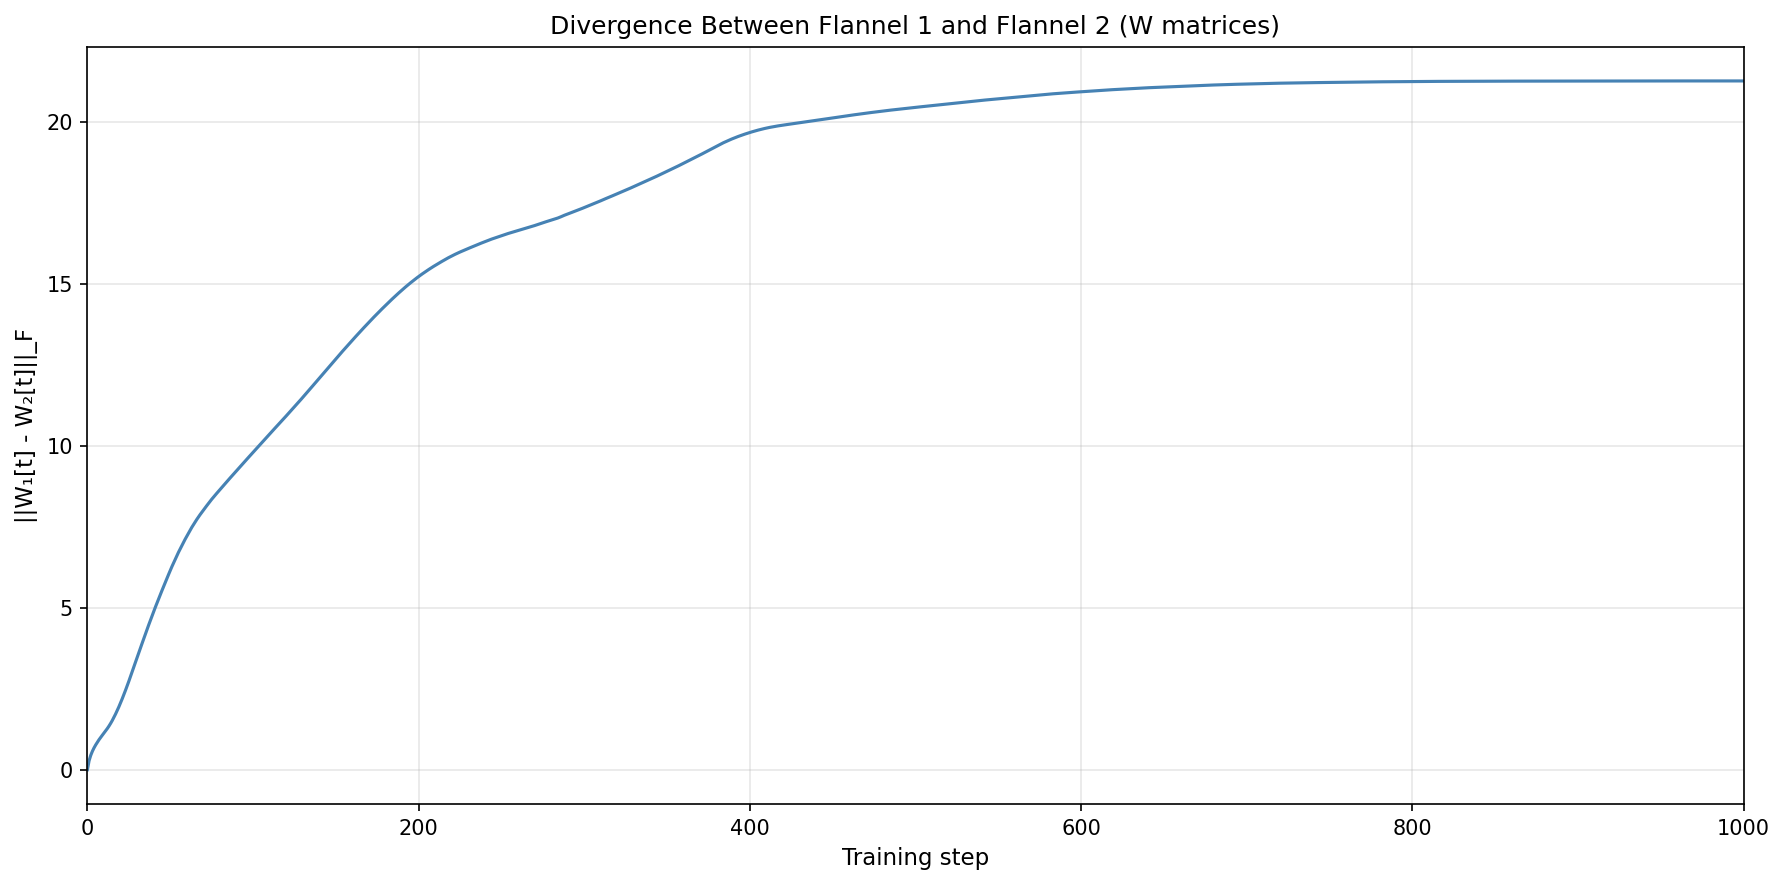

✓ Plot complete


In [16]:
print("\nPlotting Frobenius norm divergence...\n")

fig, ax = plt.subplots(figsize=(12, 6), dpi=PLOT_DPI)

ax.plot(frob_norms_cpu, linewidth=1.5, color='steelblue')
ax.set_xlabel('Training step', fontsize=11)
ax.set_ylabel('||W₁[t] - W₂[t]||_F', fontsize=11)
ax.set_title('Divergence Between Flannel 1 and Flannel 2 (W matrices)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, n_steps-1)

plt.tight_layout()
plt.show()

print("✓ Plot complete")

## Live vs Dead Token Divergence

Does divergence come from live tokens (which get different training signals) or dead tokens (which evolve based on different hidden states)?

Compute separate Frobenius norms for:
- Live token subspace: ||W₁[live, t] - W₂[live, t]||_F
- Dead token subspace: ||W₁[dead, t] - W₂[dead, t]||_F

In [17]:
print("\nComputing live vs dead token divergence...\n")

frob_live = torch.zeros(n_steps, device=device)
frob_dead = torch.zeros(n_steps, device=device)

for t in range(n_steps):
    diff = W_1[t] - W_2[t]
    
    # Live tokens
    diff_live = diff[live_mask]
    frob_live[t] = torch.norm(diff_live, p='fro')
    
    # Dead tokens
    diff_dead = diff[dead_mask]
    frob_dead[t] = torch.norm(diff_dead, p='fro')

frob_live_cpu = frob_live.cpu().numpy()
frob_dead_cpu = frob_dead.cpu().numpy()

print(f"✓ Computed live vs dead divergence")
print(f"\nLive tokens ({n_live} total):")
print(f"  t=0: {frob_live_cpu[0]:.6e}")
print(f"  t={n_steps-1}: {frob_live_cpu[-1]:.6e}")
print(f"\nDead tokens ({n_dead} total):")
print(f"  t=0: {frob_dead_cpu[0]:.6e}")
print(f"  t={n_steps-1}: {frob_dead_cpu[-1]:.6e}")


Computing live vs dead token divergence...

✓ Computed live vs dead divergence

Live tokens (6301 total):
  t=0: 0.000000e+00
  t=1000: 1.141496e+01

Dead tokens (3699 total):
  t=0: 0.000000e+00
  t=1000: 1.796134e+01


## Plot: Live vs Dead Divergence


Plotting live vs dead divergence...



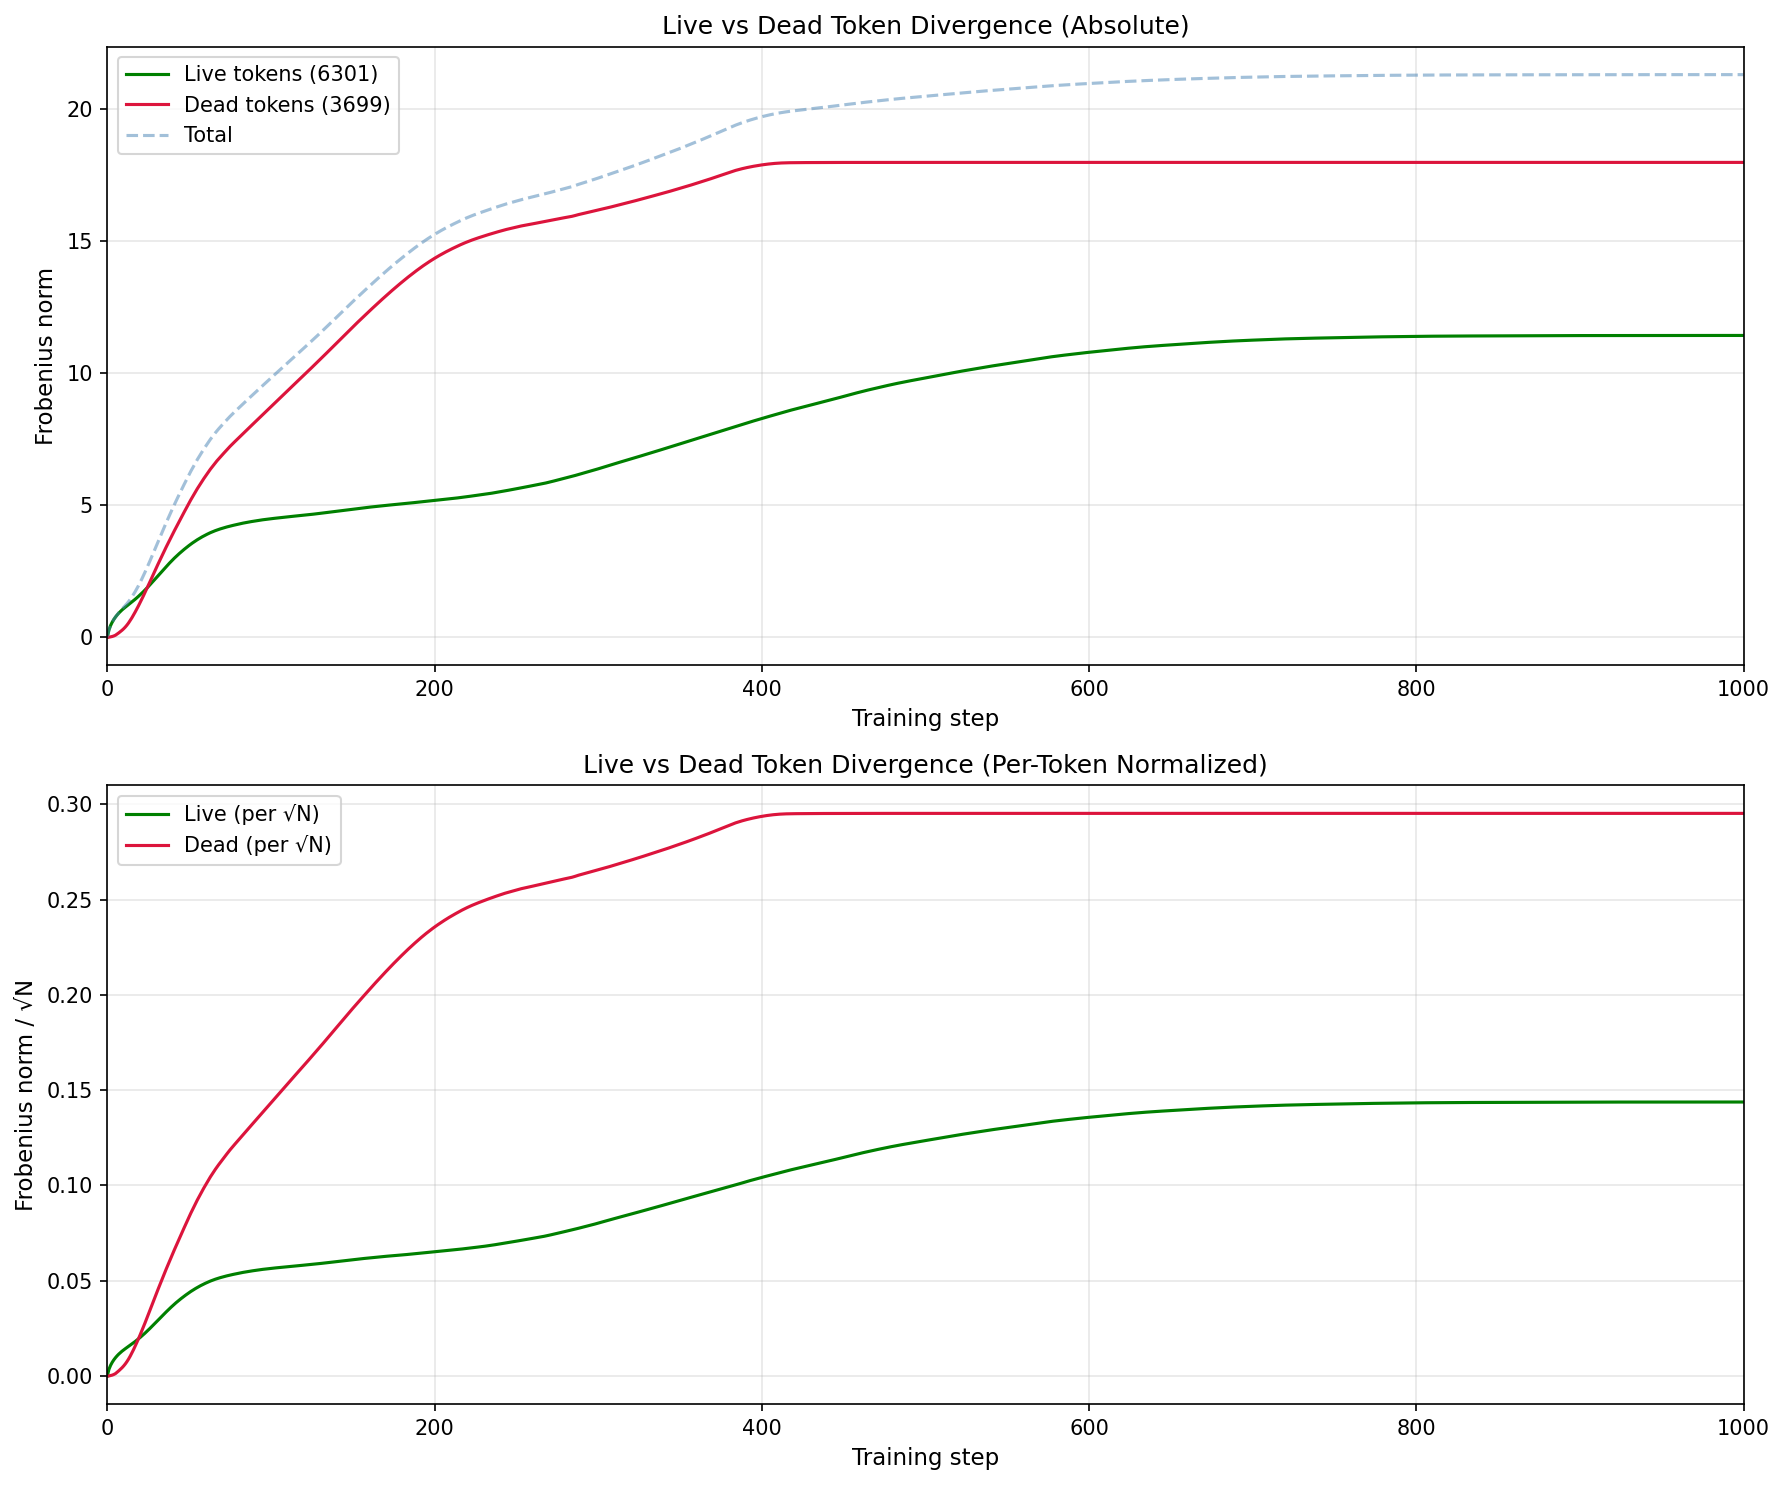

✓ Plot complete


In [18]:
print("\nPlotting live vs dead divergence...\n")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=PLOT_DPI)

# Absolute scale
ax1.plot(frob_live_cpu, linewidth=1.5, color='green', label=f'Live tokens ({n_live})')
ax1.plot(frob_dead_cpu, linewidth=1.5, color='crimson', label=f'Dead tokens ({n_dead})')
ax1.plot(frob_norms_cpu, linewidth=1.5, color='steelblue', linestyle='--', alpha=0.5, label='Total')
ax1.set_xlabel('Training step', fontsize=11)
ax1.set_ylabel('Frobenius norm', fontsize=11)
ax1.set_title('Live vs Dead Token Divergence (Absolute)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(0, n_steps-1)

# Per-token normalized scale
frob_live_per_token = frob_live_cpu / np.sqrt(n_live)
frob_dead_per_token = frob_dead_cpu / np.sqrt(n_dead)

ax2.plot(frob_live_per_token, linewidth=1.5, color='green', label=f'Live (per √N)')
ax2.plot(frob_dead_per_token, linewidth=1.5, color='crimson', label=f'Dead (per √N)')
ax2.set_xlabel('Training step', fontsize=11)
ax2.set_ylabel('Frobenius norm / √N', fontsize=11)
ax2.set_title('Live vs Dead Token Divergence (Per-Token Normalized)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(0, n_steps-1)

plt.tight_layout()
plt.show()

print("✓ Plot complete")

## Summary

In [19]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80 + "\n")

print(f"Experiment: Flannel 1 (tied weights) vs Flannel 2 (untied weights)")
print(f"  Vocab: {vocab_size} ({n_live} live, {n_dead} dead)")
print(f"  Steps: {n_steps}")
print(f"  Hidden dim: {hidden_dim}")
print()

print(f"Initial condition:")
print(f"  ||W₁[0] - W₂[0]||_F = {frob_norm_0:.6e}")
if frob_norm_0 < 1e-6:
    print(f"  ✓ Identical initialization (same seed)")
else:
    print(f"  ✗ Different initialization (investigate!)")
print()

print(f"Final divergence:")
print(f"  ||W₁[{n_steps-1}] - W₂[{n_steps-1}]||_F = {frob_norms_cpu[-1]:.6e}")
print(f"  Live tokens: {frob_live_cpu[-1]:.6e}")
print(f"  Dead tokens: {frob_dead_cpu[-1]:.6e}")
print()

if frob_norms_cpu[-1] > 100 * frob_norm_0:
    print(f"Conclusion:")
    print(f"  ✓ W₁ and W₂ DIVERGE significantly over training")
    print(f"  Tied vs untied weights produce different trajectories")
    print(f"  Divergence factor: {frob_norms_cpu[-1] / max(frob_norm_0, 1e-10):.2e}x")
    print()
    
    # Check who drives divergence
    live_fraction = (frob_live_cpu[-1]**2) / (frob_norms_cpu[-1]**2)
    dead_fraction = (frob_dead_cpu[-1]**2) / (frob_norms_cpu[-1]**2)
    
    print(f"  Divergence driven by:")
    print(f"    Live tokens: {live_fraction*100:.1f}%")
    print(f"    Dead tokens: {dead_fraction*100:.1f}%")
    
    if live_fraction > 0.8:
        print(f"\n  → Live tokens dominate (expected: they get different training signals)")
    elif dead_fraction > 0.8:
        print(f"\n  → Dead tokens dominate (surprising! investigate further)")
    else:
        print(f"\n  → Both contribute (coupled dynamics)")
else:
    print(f"Conclusion:")
    print(f"  ✗ W₁ and W₂ remain similar")
    print(f"  Tied vs untied weights make little difference")
    print(f"  This is unexpected — investigate why!")

print("\n" + "="*80)


SUMMARY

Experiment: Flannel 1 (tied weights) vs Flannel 2 (untied weights)
  Vocab: 10000 (6301 live, 3699 dead)
  Steps: 1001
  Hidden dim: 64

Initial condition:
  ||W₁[0] - W₂[0]||_F = 0.000000e+00
  ✓ Identical initialization (same seed)

Final divergence:
  ||W₁[1000] - W₂[1000]||_F = 2.128170e+01
  Live tokens: 1.141496e+01
  Dead tokens: 1.796134e+01

Conclusion:
  ✓ W₁ and W₂ DIVERGE significantly over training
  Tied vs untied weights produce different trajectories
  Divergence factor: 2.13e+11x

  Divergence driven by:
    Live tokens: 28.8%
    Dead tokens: 71.2%

  → Both contribute (coupled dynamics)

